In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import openpyxl

import os
import requests
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [2]:
os.chdir('C:\\Users\\Franco\\Python\\CAF')

In [3]:
distances = pd.read_excel('files/distances.xlsx', index_col = 0)

In [4]:
cwpops = pd.read_excel('files/cwpops.xlsx', index_col = [0,1])

In [5]:
ejd = pd.read_excel('files/analisis_ejd.xlsx',  sheet_name='Sheet1 (2)')

In [6]:
ejd = ejd.rename(columns={'Pais':'Country','Ciudad':'City'})

In [7]:
#Creo DICT para poder cambiar las siglas de los paises por los nomrbes de los paises

a = list(ejd.loc[:,'Country'].unique())

b = [
 'Brasil',
 'Costa Rica',
 'Argentina',
 'Paraguay',
 'Uruguay',
 'Mexico',
 'Peru',
 'Ecuador',
 'Bolivia',
 'Panama',
 'Venezuela',
 'Chile',
 'Colombia']

b = sorted(b)

nombres = dict(zip(a, b))

nombres['PER'] = 'Peru'
nombres['PRY'] = 'Paraguay'

In [8]:
ejd = ejd.replace({"Country": nombres}).set_index(['Country','City'])

In [9]:
#a = cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='inner').index.tolist()

#cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='outer').drop(index=a)

In [10]:
dic = pd.read_excel('files/Diccionario.xlsx',header=1,usecols='B',nrows=10)

dic.columns = ['actividad']

dic['sn'] = 's' + dic['actividad'].str[:2]

dic['sn'] = dic['sn'].str.replace(" ","")

dic['actividad'] = dic['actividad'].str[5:]

dic = dic.rename(columns={'sn':'principal_sector'})

### Acomodar el tema 'Distances' a km

In [11]:
distances['Distance2'] = distances['Distance']

In [12]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [13]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [14]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [15]:
del distances['Distance2']

### Base cutoff

In [16]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [17]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [18]:
shares_cutoff = pd.DataFrame(index = cwpops.index)

In [19]:
shares_cutoff['index1'] = shares_cutoff.index
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

In [20]:
shares_cutoff = pd.concat([shares_cutoff, shares_cutoff.mean().to_frame(('Promedios','Promedios')).T])

### Base Congestion

In [21]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [22]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

#### Calculo de congestión promedio

Mantengo sólo ciudades que se encuentran a menos de 12 horas de la ciudad objetivo

In [23]:
distances = distances.replace('NAN', np.nan)

In [24]:
cerca = distances.loc[(distances['duration_traffic'] <= 12),:]

City B: filtro por ciudades con masa salarial (% del total del país) mayor a la mediana del país

In [25]:
citywage = pd.DataFrame(cwpops.loc[:,'estimated_citywage'])

a = citywage.groupby('Country').sum('estimated_citywage')
a.rename(columns={'estimated_citywage':'country_wage'},inplace=True)

citywage = a.join(citywage,how='inner')

citywage['wage_ratio'] = citywage['estimated_citywage'] / citywage['country_wage']

citywage.dropna(subset=['wage_ratio'],inplace=True)

In [26]:
a = pd.DataFrame(citywage.loc[:,'wage_ratio'].groupby('Country').median('wage_ratio'))

a.rename(columns={'wage_ratio':'median_wr'},inplace=True)

In [27]:
citywage = a.join(citywage,how='inner')

In [28]:
mercados_target = citywage.loc[(citywage['wage_ratio']>citywage['median_wr']),:]

Ahora filtro mi base de distancias dejando solo los mercados target dentro de las city B

In [29]:
mercados_target.reset_index(inplace=True)
mercados_target.rename(columns={'City':'City B'},inplace=True)
mercados_target.drop(columns=['Country','median_wr','country_wage'],inplace=True)

In [30]:
cerca_mercado = cerca.merge(mercados_target,on='City B', how='inner',validate='m:1',)

In [31]:
cerca_mercado['kms_hora'] = cerca_mercado['distance_km'] / cerca_mercado['duration_traffic']

Ahora tengo que crear las distancias x hora recorridas promedio de cada ciudad para 3 6 9 y 12 horas max

In [38]:
cm = pd.DataFrame(np.nan ,index = cerca_mercado.index.unique(),columns=['dist_3horas','dist_6horas','dist_9horas','dist_12horas'])

In [33]:
mylist = [3,6,9,12]

cerca_mercado = cerca_mercado.rename(columns={'City A':'City'}).set_index(['Country','City'])

In [34]:
#Cerca mercado es la base de distances en la que las ciudades destino estan a menos de 12 horas 
#y corresponden a masas salariares superiores a la mediana del pais

In [35]:
#cerca_mercado.query('(Country == "Argentina" and City == "Bahia Blanca-Cerri") and duration_traffic <= 9').loc[:,'kms_hora'].mean()

In [40]:
for i,r in cm.iterrows():
    p = cerca_mercado.loc[i,:]
    for e in mylist:
        cm.loc[i,'dist_{}horas'.format(e)] = p.loc[(p['duration_traffic'] <= e),'kms_hora'].mean()

### Mexico

In [41]:
mex = cwpops.loc['Mexico'].sort_values('pops',ascending=False).iloc[7:37,]

In [42]:
ejd_mex = ejd.loc['Mexico']

In [43]:
a = ejd_mex.reset_index().apply(lambda row: row['City'].replace('Zona metropolitana de ','').replace('Zona metropolitana del ',''),axis=1).to_frame()

In [44]:
ejd_mex = ejd_mex.reset_index().join(a,how='inner')

In [45]:
ejd_mex = ejd_mex.rename(columns={'City':'City_old',0:'City'}).set_index('City')

In [394]:
#mex.join(ejd_mex,how='outer').loc[:,['index1','nearest_loc','City_old']]

,index1,nearest_loc,City_old
City,,,
Acapulco,"('Mexico', 'Acapulco')","('Mexico', 'Zona metropolitana de Acapulco')",Zona metropolitana de Acapulco
Aguascalientes,NaN,NaN,Zona metropolitana de Aguascalientes
Cancún,"('Mexico', 'Cancún')","('Mexico', 'Zona metropolitana de Cancún')",Zona metropolitana de Cancún
Chihuahua,"('Mexico', 'Chihuahua')","('Mexico', 'Zona metropolitana de Chihuahua')",Zona metropolitana de Chihuahua
Colima-Villa de Álvarez,"('Mexico', 'Colima-Villa de Álvarez')","('Mexico', 'Zona metropolitana de Colima-Villa...",Zona metropolitana de Colima-Villa de Álvarez
Cuernavaca,"('Mexico', 'Cuernavaca')","('Mexico', 'Zona metropolitana de Cuernavaca')",Zona metropolitana de Cuernavaca
Culiacán,NaN,NaN,Culiacán
Durango,"('Mexico', 'Durango')","('Mexico', 'Durango')",Durango
Guadalajara,NaN,NaN,Zona metropolitana de Guadalajara


Lejos de Mercados

In [47]:
sc_mex = shares_cutoff.drop(columns=['index1']).loc['Mexico'].loc[mex.index.tolist()].sort_values('cutoff_9').iloc[:10,:]

In [48]:
sc_mex = sc_mex.loc[(sc_mex['cutoff_9']<0.1),:]

In [102]:
scmex_stack = sc_mex.stack(dropna=False).to_frame().reset_index().set_index(['City']).rename(columns={'level_1':'horas',0:'% MS alcanzada'})

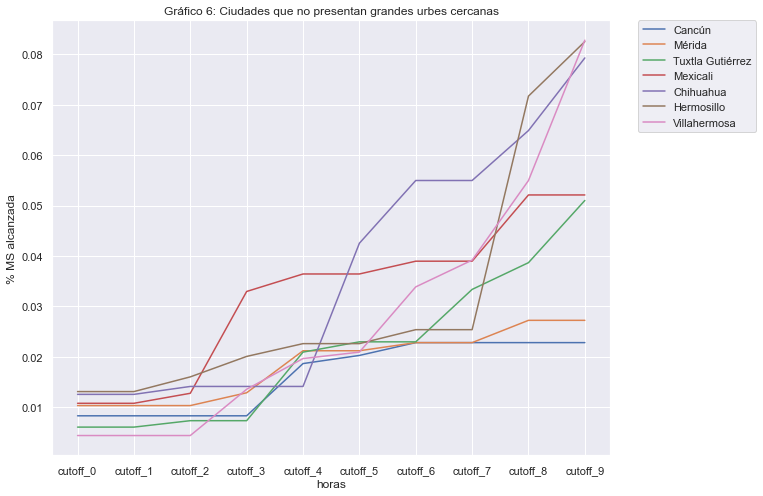

In [103]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=scmex_stack, x="horas", y="% MS alcanzada" , hue = 'City').set_title('Gráfico 6: Ciudades que no presentan grandes urbes cercanas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig("Entregables/Indicadores/Mexico/lejanas.png",bbox_inches='tight')

In [49]:
sc_mex.to_excel("Entregables/Indicadores/Mexico/lejanas.xlsx")

In [65]:
mylist = [ejd.columns.tolist()[e] for e in [0,2,9,-1]]

In [73]:
lejanos_tab = sc_mex.join(ejd_mex,how='inner').loc[:,mylist].join(mex.loc[:,['estimated_hourly_wage_US','pops']],how='inner').reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').drop(columns=['principal_sector'])

In [75]:
lejanos_tab = lejanos_tab.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)', 'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [76]:
cols = lejanos_tab.columns.tolist()

In [78]:
cols = [cols[-1]] + cols[:-1] 

lejanos_tab = lejanos_tab[cols]

In [80]:
lejanos_tab.to_excel('Entregables/Indicadores/Mexico/tabla_lejanas.xlsx')

Urbe significativas cerca

In [134]:
sc_mex2 = shares_cutoff.drop(columns=['index1']).loc['Mexico'].loc[mex.index.tolist()]

In [135]:
sc_mex2['crec_ms'] = (sc_mex2['cutoff_9'] / sc_mex2['cutoff_0']) - 1

In [138]:
sc_mex2 = sc_mex2['crec_ms'].to_frame()

In [448]:
sel2 = sc_mex2.join(mex.loc[:,['masalarial','estimated_hourly_wage_US','pops']],how='left').loc[(sc_mex2['crec_ms']>10),:].sort_values('pops',ascending=False).iloc[:10,:]

In [449]:
sel2.join(shares_cutoff,how='left').sort_values('pops',ascending=False).iloc[:,5:].to_excel('Entregables/Indicadores/Mexico/cercanas.xlsx')

In [472]:
tab2 = sel2.iloc[:,:2].join(ejd_mex, how='inner').reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').join(mex.loc[:,['estimated_hourly_wage_US','pops']],how='left').drop(columns=['crec_ms','masalarial','City_old','principal_sector','HH','HH_pais','nivedu1','nivedu2','esp_HH','formal','country_principal_sector_share','principal_sector_country_comparison','mujer','hombre']).rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)',
       'nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})


In [473]:
cols = tab2.columns.tolist()

cols = [cols[3]] + cols[:3] + cols[-2:]

tab2 = tab2[cols]

In [475]:
tab2.to_excel('Entregables/Indicadores/Mexico/tabla_cercanas.xlsx')

Congestion

In [91]:
cm_mex = cm.loc['Mexico']

In [103]:
sel3 = cm_mex.join(mex.loc[(mex['pops']>400000),['pops']],how='inner').sort_values('dist_3horas').iloc[:10,:]

In [114]:
sel3.to_excel('Entregables/Indicadores/Mexico/congestion.xlsx')

In [120]:
sel3_tab = sel3.iloc[:,-1].to_frame().join(mex.loc[:,['estimated_hourly_wage_US']],how='inner').join(ejd_mex.loc[:,['principal_sector','principal_sector_share','nivedu3','informal']],how='inner')

In [123]:
sel3_tab = sel3_tab.reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').drop(columns=['principal_sector'])

In [126]:
sel3_tab = sel3_tab.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [127]:
sel3_tab.columns

Index(['población estimada', 'salario promedio (usd/hora)',
       '% principal sector', '% edu3 (+14 años)', '% de informalidad laboral',
       'principal sector'],
      dtype='object')

In [128]:
cols = sel3_tab.columns.tolist()

In [129]:
cols = [cols[-1]] + cols[2:5] + [cols[1]] + [cols[0]]

sel3_tab = sel3_tab[cols]

In [131]:
sel3_tab.to_excel('Entregables/Indicadores/Mexico/congestion_tabla.xlsx')

### Colombia

In [133]:
cwpops.loc['Colombia'].shape

(26, 11)

In [134]:
ejd.loc['Colombia'].shape

(23, 14)

In [157]:
col = cwpops.loc['Colombia'].join(ejd.loc['Colombia'],how='inner').loc[:,['principal_sector','principal_sector_share','nivedu3','informal','estimated_hourly_wage_US','pops',]].reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').drop(columns=['principal_sector'])

In [164]:
cols = col.columns.tolist()
cols = [cols[-1]] + cols[:-1]

In [166]:
col = col[cols]

In [184]:
#acomodo pob de Armenia
col.iloc[0,-1] = 295208

In [199]:
sel_col = col.sort_values('pops',ascending=False).iloc[3:15,:].rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

Lejanas

In [200]:
sc_col = shares_cutoff.loc['Colombia'].loc[sel_col.index].drop(columns=['index1'])

In [201]:
sc_col.loc[(sc_col['cutoff_9']<0.15),:].to_excel('Entregables/Indicadores/Colombia/lejanas.xlsx')

In [203]:
sel_col.loc[sc_col.loc[(sc_col['cutoff_9']<0.15),:].index].to_excel('Entregables/Indicadores/Colombia/lejanas_tab.xlsx')

cercanas

In [211]:
sel_col2 =  col.sort_values('pops',ascending=False).iloc[3:15,:].rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [212]:
sc_col2 = shares_cutoff.loc['Colombia'].loc[sel_col2.index].drop(columns=['index1'])

In [213]:
sc_col2['crec_ms'] = (sc_col2['cutoff_9'] / sc_col2['cutoff_0']) - 1

In [217]:
sc_col2.sort_values('crec_ms',ascending=False).iloc[:5,:].to_excel('Entregables/Indicadores/Colombia/cercanas.xlsx')

In [221]:
sel_col.loc[sc_col2.sort_values('crec_ms',ascending=False).iloc[:5,:].index].to_excel('Entregables/Indicadores/Colombia/cercanas_tab.xlsx')

Congestión

In [230]:
sel_col3 =  col.sort_values('pops',ascending=False).iloc[3:15,:].rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [231]:
cm_col = cm.loc['Colombia']

In [528]:
cm_col.loc[sel_col3.index].dropna().sort_values('dist_3horas').to_excel('Entregables/Indicadores/Colombia/congestion.xlsx')

In [237]:
sel_col3.loc[cm_col.loc[sel_col3.index].dropna().sort_values('dist_3horas').index].to_excel('Entregables/Indicadores/Colombia/congestion_tab.xlsx')

## Resto de Latam

In [260]:
mylist = ['Peru','Chile','Panama','Bolivia','Ecuador','Costa Rica']

In [318]:
#cwpops.query('(Country.ist "Argentina" and City == "Bahia Blanca-Cerri") and duration_traffic <= 9')

In [317]:
latam = cwpops.reset_index().loc[cwpops.reset_index().isin(mylist)['Country']].set_index(['Country','City'])

In [341]:
ejd_latam = ejd.loc[:,['principal_sector','principal_sector_share' , 'nivedu3','informal']].join(latam.loc[:,['estimated_hourly_wage_US','pops']],how='inner')

In [349]:
a = latam.join(ejd_latam.loc[:,'principal_sector'],how='outer')

In [358]:
missing = a[a['principal_sector'].isna()]

In [379]:
#latam.iloc[:,[3,9]].join(ejd,how='inner')
sel_latam = ejd_latam.reset_index().merge(dic,on='principal_sector',validate='m:1').set_index(['Country','City']).rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'}).iloc[:,1:]

In [386]:
cols = sel_latam.columns

In [387]:
cols

Index(['% principal sector', '% edu3 (+14 años)', '% de informalidad laboral',
       'salario promedio (usd/hora)', 'población estimada',
       'principal sector'],
      dtype='object')

In [394]:
cols = [cols[-1]] + cols[:-1].tolist()

In [395]:
sel_latam = sel_latam[cols]

In [398]:
sel_latam.groupby('Country').count()

,principal sector,% principal sector,% edu3 (+14 años),% de informalidad laboral,salario promedio (usd/hora),población estimada
Country,,,,,,
Bolivia,12,12,12,12,12,12
Chile,37,37,37,37,37,37
Costa Rica,5,5,5,5,5,5
Ecuador,18,18,18,18,18,18
Panama,11,11,11,11,11,11
Peru,42,42,42,42,42,42


In [412]:
mydict={}

for i in mylist:
    mydict['{}'.format(i)] = ''

mydict['Peru'] = 4
mydict['Chile'] = 4
mydict['Ecuador'] = 2
mydict['Bolivia'] = 2
mydict['Panama'] = 2
mydict['Costa Rica'] = 1

In [434]:
for key, value in mydict.items():
    valor = value*3
    sel_latam.loc[key].sort_values('población estimada',ascending=False).iloc[1:valor].to_excel('Entregables/Indicadores/Latam/{}.xlsx'.format(key))

In [440]:
sel_latam.loc['Bolivia'].sort_values('población estimada',ascending=False).iloc[:3,:].to_excel('Entregables/Indicadores/Latam/Bolivia.xlsx')

In [449]:
sel_latam.loc['Ecuador'].sort_values('población estimada',ascending=False).iloc[:6,:].to_excel('Entregables/Indicadores/Latam/Ecuador.xlsx')

In [453]:
sel_latam.loc['Costa Rica'].sort_values('población estimada',ascending=False).iloc[:3,:].to_excel('Entregables/Indicadores/Latam/Costa Rica.xlsx')

### Argentina

In [490]:
arg = cwpops.loc['Argentina',['pops','estimated_hourly_wage_US']].join(ejd.loc['Argentina',['principal_sector','principal_sector_share','nivedu3','informal']],how='inner')

In [491]:
arg = arg.reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').drop(columns=['principal_sector'])

In [492]:
arg = arg.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [493]:
cols = arg.columns.tolist()

In [495]:
cols = [cols[-1]] + cols[2:5] + [cols[1]] + [cols[0]]

In [496]:
arg = arg[cols]

In [584]:
sel_arg = arg.sort_values('población estimada',ascending=False).iloc[2:27,:]

In [593]:
sel_arg.shape

(25, 6)

Lejanas

In [586]:
sc_arg = shares_cutoff.loc['Argentina'].loc[sel_arg.index].drop(columns=['index1'])

In [587]:
sc_arg.sort_values('cutoff_9')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9
City,,,,,,,,,,
Comodoro Rivadavia-Rada Tilly,0.012,0.012,0.012,0.012,0.012,0.012,0.013,0.013,0.013,0.018
Posadas,0.007,0.007,0.007,0.007,0.015,0.022,0.022,0.033,0.033,0.041
Formosa,0.006,0.006,0.006,0.021,0.021,0.021,0.021,0.028,0.028,0.046
Corrientes,0.008,0.016,0.016,0.021,0.028,0.028,0.033,0.033,0.073,0.073
Gran San Juan,0.012,0.012,0.012,0.015,0.015,0.020,0.028,0.035,0.083,0.083
Jujuy-Palpala,0.007,0.007,0.020,0.020,0.020,0.061,0.080,0.080,0.085,0.090
Salta,0.014,0.014,0.020,0.020,0.061,0.061,0.080,0.085,0.085,0.090
Gran Resistencia,0.007,0.016,0.016,0.021,0.021,0.028,0.028,0.046,0.073,0.115
Gran Tucuman-Tafi Viejo,0.040,0.040,0.040,0.064,0.078,0.090,0.090,0.134,0.134,0.134


In [510]:
sc_arg.loc[(sc_arg['cutoff_9']<0.2),:].to_excel('Entregables/Indicadores/Argentina/lejanas.xlsx')

In [511]:
sel_arg.loc[sc_arg.loc[(sc_arg['cutoff_9']<0.2),:].index].to_excel('Entregables/Indicadores/Argentina/lejanas_tab.xlsx')

Cercanas

In [588]:
sc_arg2 = sc_arg
sc_arg2['crec_ms'] = (sc_arg['cutoff_9'] / sc_arg['cutoff_0']) - 1

In [591]:
sc_arg2.sort_values('crec_ms',ascending=False).iloc[:6,:].to_excel('Entregables/Indicadores/Argentina/cercanas.xlsx')

In [592]:
sel_arg.loc[sc_arg2.sort_values('crec_ms',ascending=False).iloc[:6,:].index].to_excel('Entregables/Indicadores/Argentina/cercanas_tab.xlsx')

Congestión

In [525]:
cm_arg = cm.loc['Argentina']

In [529]:
cm_arg.loc[sel_arg.index].dropna().sort_values('dist_3horas').to_excel('Entregables/Indicadores/Argentina/congestion.xlsx')

In [530]:
sel_arg.loc[cm_arg.loc[sel_arg.index].dropna().sort_values('dist_3horas').index].to_excel('Entregables/Indicadores/Argentina/congestion_tab.xlsx')

### Brasil

In [532]:
bra = cwpops.loc['Brasil',['pops','estimated_hourly_wage_US']].join(ejd.loc['Brasil',['principal_sector','principal_sector_share','nivedu3','informal']],how='inner')

In [536]:
bra = bra.reset_index().merge(dic,on='principal_sector',validate='m:1').set_index('City').drop(columns=['principal_sector'])

In [538]:
bra = bra.rename(columns={'principal_sector_share':'% principal sector', 'nivedu1':'% edu1 (0-8 años)','nivedu2':'% edu2 (9-13 años)', 'nivedu3':'% edu3 (+14 años)', 'formal':'% de formalidad laboral', 'informal':'% de informalidad laboral', 'actividad' :'principal sector','estimated_hourly_wage_US':'salario promedio (usd/hora)','pops':'población estimada'})

In [539]:
cols = bra.columns.tolist()

In [540]:
cols = [cols[-1]] + cols[2:5] + [cols[1]] + [cols[0]]

In [541]:
bra = bra[cols]

In [548]:
sel_bra = bra.sort_values('población estimada',ascending=False).iloc[2:15,:]

Lejanas

In [549]:
sc_bra = shares_cutoff.loc['Brasil'].loc[sel_bra.index].drop(columns=['index1'])

In [550]:
sc_bra.sort_values('cutoff_9')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9
City,,,,,,,,,,
Sao Luis,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.011,0.020,0.020
Manaus,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.020
Brasilia,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051
Fortaleza,0.027,0.027,0.027,0.027,0.030,0.030,0.030,0.031,0.042,0.053
Teresina,0.007,0.007,0.008,0.008,0.008,0.009,0.011,0.011,0.021,0.053
Goiania,0.021,0.021,0.025,0.027,0.029,0.036,0.040,0.046,0.061,0.068
Recife,0.020,0.020,0.032,0.032,0.056,0.058,0.058,0.065,0.067,0.069
Salvador,0.033,0.035,0.042,0.042,0.042,0.049,0.051,0.057,0.063,0.075
Natal,0.008,0.008,0.008,0.017,0.041,0.044,0.046,0.058,0.085,0.089


In [559]:
sc_bra.loc[(sc_bra['cutoff_9']<0.08),:].to_excel('Entregables/Indicadores/Brasil/lejanas.xlsx')

In [560]:
sel_bra.loc[sc_bra.loc[(sc_bra['cutoff_9']<0.08),:].index].to_excel('Entregables/Indicadores/Brasil/lejanas_tab.xlsx')

Cercanas

In [556]:
sc_bra2 = sc_bra
sc_bra2['crec_ms'] = (sc_bra['cutoff_9'] / sc_bra['cutoff_0']) - 1

In [563]:
sc_bra2.sort_values('crec_ms',ascending=False).iloc[:8,:].to_excel('Entregables/Indicadores/Brasil/cercanas.xlsx')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms
City,,,,,,,,,,,
Belo Horizonte,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.122,0.346,0.346,15.308
Natal,0.008,0.008,0.008,0.017,0.041,0.044,0.046,0.058,0.085,0.089,9.985
Maceio,0.010,0.010,0.010,0.016,0.037,0.044,0.057,0.057,0.068,0.107,9.224
Teresina,0.007,0.007,0.008,0.008,0.008,0.009,0.011,0.011,0.021,0.053,6.221
Porto Alegre,0.028,0.028,0.034,0.034,0.051,0.058,0.067,0.077,0.086,0.145,4.196
Curitiba,0.058,0.058,0.071,0.074,0.091,0.094,0.134,0.160,0.179,0.231,2.959
Recife,0.020,0.020,0.032,0.032,0.056,0.058,0.058,0.065,0.067,0.069,2.381
Goiania,0.021,0.021,0.025,0.027,0.029,0.036,0.040,0.046,0.061,0.068,2.310


In [564]:
sel_bra.loc[sc_bra2.sort_values('crec_ms',ascending=False).iloc[:8,:].index].to_excel('Entregables/Indicadores/Brasil/cercanas_tab.xlsx')

Congestion

In [566]:
cm_bra = cm.loc['Brasil']

In [568]:
cm_bra.loc[sel_bra.index].dropna().sort_values('dist_3horas').to_excel('Entregables/Indicadores/Brasil/congestion.xlsx')

In [569]:
sel_bra.loc[cm_bra.loc[sel_bra.index].dropna().sort_values('dist_3horas').index].to_excel('Entregables/Indicadores/Brasil/congestion_tab.xlsx')